In [1]:
import torch
import torchvision.models as models
from torchvision import models,datasets,transforms
import os
import shutil
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import TrashNet data

In [3]:
def copy_all_to_test(data_dir, output_dir):
    class_mapping = {
        "cardboard": "cardboard",  
        "glass": "glass",
        "metal": "metal",
        "paper": "paper",
        "plastic": "plastic",
        "trash": "trash",
    }
 
    ignored_folders = {"Textile Trash", "Vegetation"}
 
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(test_dir, exist_ok=True)
 
    records = []
 
    for class_name in os.listdir(data_dir):
        if class_name in ignored_folders:
            print(f"Skipping {class_name} (ignored)")
            continue
 
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
 
        mapped_class = class_mapping.get(class_name, class_name)
 
        class_test_dir = os.path.join(test_dir, mapped_class)
        os.makedirs(class_test_dir, exist_ok=True)
 
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
 
        print(f"Copying {len(images)} images from {class_name} to {mapped_class} in test set...")
 
        for image in images:
            dest = os.path.join(class_test_dir, os.path.basename(image))
            shutil.copy(image, dest)
            records.append((os.path.basename(image), class_name, mapped_class, "test"))
 
    df = pd.DataFrame(records, columns=['filename', 'original_class', 'mapped_class', 'split_type'])
    df.to_csv(os.path.join(output_dir, 'class_mapping.csv'), index=False)
 
    print("All images successfully copied to the test set!")
 
# Set the paths
original_data_dir = '../data/dataset-resized'
output_data_dir = '../data/dataset_split'

copy_all_to_test(original_data_dir, output_data_dir)

Copying 594 images from paper to paper in test set...
Copying 410 images from metal to metal in test set...
Copying 403 images from cardboard to cardboard in test set...
Copying 137 images from trash to trash in test set...
Copying 501 images from glass to glass in test set...
Copying 482 images from plastic to plastic in test set...
All images successfully copied to the test set!


In [4]:
dir = '../data/dataset_split'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(os.path.join(dir, 'test'),transform = transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Import RealWaste data

In [2]:
dir = '../data/realwaste-main'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = datasets.ImageFolder(os.path.join(dir, 'dataset_analysis'),transform = transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Testing procedure

In [5]:
model = models.densenet121(pretrained=False)
num_classes = 6
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model_path = "saved_models/trained_combined_modell_val_densenet.pth"
model.load_state_dict(torch.load(model_path))

model.eval()

/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/bn/9jpk7_vs2wz__6f0k16kkrdw0000gn/T/ipykernel_76928/3912033966.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
y_true = [] 
y_pred = [] 

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)

## Testing outcomes

### Get class-wise accuracy

In [ ]:
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

for i in range(len(y_true)):
    label = y_true[i]
    if y_true[i] == y_pred[i]:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Accuracy of class {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')


Accuracy of class cardboard: 72.46%
Accuracy of class glass: 77.45%
Accuracy of class metal: 79.51%
Accuracy of class paper: 71.38%
Accuracy of class plastic: 37.55%
Accuracy of class trash: 6.57%


### Generate classification report

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.57      0.72      0.64       403
       glass       0.60      0.77      0.67       501
       metal       0.61      0.80      0.69       410
       paper       0.76      0.71      0.74       594
     plastic       0.74      0.38      0.50       482
       trash       0.38      0.07      0.11       137

    accuracy                           0.64      2527
   macro avg       0.61      0.57      0.56      2527
weighted avg       0.65      0.64      0.62      2527



Text(0.5, 1.0, 'Confusion Matrix Heatmap')

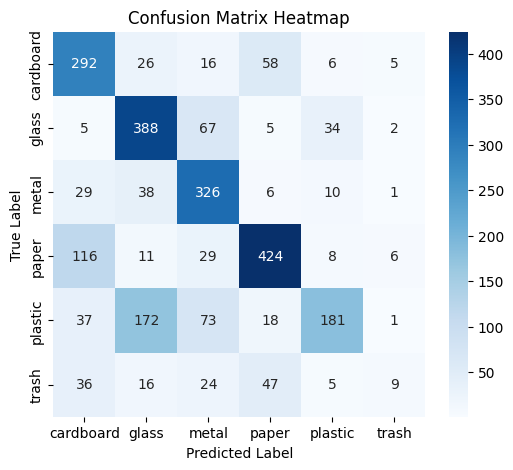

In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")